### Imports

In [80]:
import sqlite3
import pprint
from time import time
import matplotlib.pyplot as plt
import numpy as np

### Connect to the DB

In [57]:
db = sqlite3.connect("sqlite3_group10.db")
cur = db.cursor()

## Simple Queries

### Simple Query 1 - Unarmed Males under 18 killed by Police

In [58]:
simple_query_1 = '''
    SELECT name, age 
    FROM police_killings 
    WHERE age < 18 
    AND gender = "M" 
    AND armed = "unarmed" 
    ORDER BY age;
'''

results = cur.execute(simple_query_1).fetchall()

pprint.pprint(results)

[('Jeremy Mardis', 6),
 ('Jordan Edwards', 15),
 ('Jose Raul Cruz', 16),
 ('Armando Garcia-Muro', 17),
 ('David Joseph', 17),
 ('Deven Guilford', 17)]


### Simple Query 2 - Women killed by Police while not fleeing and not armed

In [59]:
simple_query_2 = '''
    SELECT name, age
    FROM police_killings
    WHERE gender = "F"
    AND flee = "Not fleeing"
    AND armed = "unarmed"
    ORDER BY age;
'''

results = cur.execute(simple_query_2).fetchall()

pprint.pprint(results)

[('Ciara Meyer', 12),
 ('Alteria Woods', 21),
 ('India Kager', 28),
 ('Autumn Steele', 34),
 ('Justine Damond', 40)]


### Simple Query 3 - People with NULL values regarding age, race and armed

In [60]:
simple_query_3 = '''
    SELECT name, gender, date
    FROM police_killings
    WHERE age IS NULL
    AND race_id IS NULL
    AND armed IS NULL;
'''

results = cur.execute(simple_query_3).fetchall()

pprint.pprint(results)

[('TK TK', 'M', '16-11-11')]


## Complex Queries

#### Complex Query 1 - People above 20 armed with a knife shot and Tasered by police in the state of Texas

In [61]:
complex_query_1 = '''
    SELECT p.name, p.age
    FROM police_killings p
    LEFT JOIN city c
    ON c.id = p.city_id
    LEFT JOIN state s
    ON c.state_id = s.id
    WHERE s.acronym = "TX"
    AND p.age > 20
    AND p.manner_of_death = "shot and Tasered"
    AND p.armed = "knife";
'''

results = cur.execute(complex_query_1).fetchall()
    
for x in results:
    print(x)

('Gregory Mathis', 36)
('Randall Lance Hughes', 48)
('Rodney Henderson', 48)
('Henry Reyna', 49)
('Ray Valdez', 55)


#### Complex Query 2 - State with the most shootings against males under the age of 18

In [62]:
complex_query_2 = '''
SELECT state, MAX(mycount)
FROM (SELECT s.acronym as state, COUNT(p.name) mycount
    FROM police_killings p
    INNER JOIN city c
    ON c.id = p.city_id
    INNER JOIN state s
    ON s.id = c.state_id
    WHERE p.gender = "M"
    AND p.age < 18
    GROUP BY s.acronym);
'''

results = cur.execute(complex_query_2).fetchall()

for x in results:
    print(f"{{\'_id\': \'{x[0]}\', \'shootings\': {x[1]}}}")

{'_id': 'CA', 'shootings': 11}


### Insert Query - Insert new police killing

In [63]:
john = ("John Smith", "20-02-25", "shot", "toy weapon", 34, "M", 1, 1, 1, "attack", None, 1)


query = '''
    INSERT INTO police_killings (name, date, manner_of_death, armed, age, gender, race_id, city_id, signs_of_mental_illness, threat_level, flee, body_camera) 
    VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,?);
'''

try:
    cur.execute(query, john)
    db.commit()
    print("Inserted successfully in police_killings")
except:
    print("Error inserting in police_killings")
    db.rollback()

Inserted successfully in police_killings


### Update Query - Update the date of the police killing by the person's name

In [64]:
query = "UPDATE police_killings SET date=? WHERE id=?;"

try:
    cur.execute(query, ("22-02-25", cur.lastrowid))
    db.commit()
    print("Successfully updated police_killings")
except:
    print("Error updating police_killings")
    db.rollback()

Successfully updated police_killings


# Optimization and indexing

In [65]:
# Number of iterations used in performance
iterations = 200

# Get average performance
def performance(query):
    result = 0
    for _ in range(iterations):
        time_i = time()
        cur.execute(query)
        time_f = time()
        result += time_f-time_i
    return result / iterations

### Dropping indexes (in case there were some)

In [66]:
drop_index_1 = "DROP INDEX IF EXISTS police_killings_index;"
cur.execute(drop_index_1)

drop_index_2 = "DROP INDEX IF EXISTS police_killings_index_2;"
cur.execute(drop_index_2)

drop_index_3 = "DROP INDEX IF EXISTS state_index;"
cur.execute(drop_index_3)

### Performance without indexes

In [67]:
# Get performance for all queries
performance_no_index = {
    "simple_query_1" : performance(simple_query_1),
    "simple_query_2" : performance(simple_query_2),
    "complex_query_1" : performance(complex_query_1),
    "complex_query_2" : performance(complex_query_2)
}

### Creating relevant indexes

In [68]:
index_1 = '''
CREATE INDEX IF NOT EXISTS police_killings_index ON police_killings(armed, gender, age, flee, manner_of_death, name)
'''
cur.execute(index_1)

index_2 = '''
CREATE INDEX IF NOT EXISTS police_killings_index_2 ON police_killings(gender, age, city_id)
'''
cur.execute(index_2)

# # acronyms of states cannot be repeated
index_3 = "CREATE UNIQUE INDEX IF NOT EXISTS state_index ON state(acronym)"
cur.execute(index_3)

### Show indexes are created

In [69]:
# print indexes that were created
created_indexes = '''
SELECT * FROM sqlite_master WHERE type = 'index';
'''
cur.execute(created_indexes)
records_query1 = cur.fetchall()
pprint.pprint(records_query1)

[('index', 'sqlite_autoindex_city_1', 'city', 5, None),
 ('index',
  'police_killings_index',
  'police_killings',
  1147,
  'CREATE INDEX police_killings_index ON police_killings(armed, gender, age, '
  'flee, manner_of_death, name)\n'),
 ('index',
  'police_killings_index_2',
  'police_killings',
  1180,
  'CREATE INDEX police_killings_index_2 ON police_killings(gender, age, '
  'city_id)\n'),
 ('index',
  'state_index',
  'state',
  1190,
  'CREATE UNIQUE INDEX state_index ON state(acronym)')]


### Optimized complex queries

In [70]:
optimized_complex_query_1 = '''
    SELECT p.name, p.age
    FROM police_killings p
    INNER JOIN city c
    ON c.id = p.city_id
    INNER JOIN state s
    ON c.state_id = s.id
    WHERE s.acronym = "TX"
    AND p.age > 20
    AND p.manner_of_death= "shot and Tasered"
    AND p.armed = "knife";
'''

results = cur.execute(optimized_complex_query_1).fetchall()

pprint.pprint(results)

[('Gregory Mathis', 36),
 ('Randall Lance Hughes', 48),
 ('Rodney Henderson', 48),
 ('Henry Reyna', 49),
 ('Ray Valdez', 55)]


In [71]:
optimized_complex_query_2 = '''
    SELECT s.acronym, (COUNT(p.name)) as mycount
    FROM police_killings p
    INNER JOIN city c
    ON c.id = p.city_id
    INNER JOIN state s
    ON s.id = c.state_id
    WHERE p.age < 18
    AND p.gender = "M"
    GROUP BY s.acronym
    ORDER BY (COUNT(p.name)) DESC
    LIMIT 1;
'''

results = cur.execute(optimized_complex_query_2).fetchall()

for x in results:
    print(f"{{\'_id\': \'{x[0]}\', \'shootings\': {x[1]}}}")

{'_id': 'CA', 'shootings': 11}


### Performance with indexes and optimization

In [72]:
# Get performance for all queries
performance_index_opt = {
    "simple_query_1" : performance(simple_query_1),
    "simple_query_2" : performance(simple_query_2),
    "complex_query_1" : performance(optimized_complex_query_1),
    "complex_query_2" : performance(optimized_complex_query_2)
}

In [86]:
# Run to see what indexes is the query using
pprint.pprint(cur.execute("EXPLAIN QUERY PLAN " + simple_query_1).fetchall())

[(3,
  0,
  0,
  'SEARCH police_killings USING COVERING INDEX police_killings_index (armed=? '
  'AND gender=? AND age<?)')]


### Performance of queries with and without indexes

In [74]:
print('Times without indexes and optimization:')
pprint.pprint(performance_no_index)

print('\nTimes with indexes and optimization:')
pprint.pprint(performance_index_opt)

Times without indexes and optimization:
{'complex_query_1': 0.0001222383975982666,
 'complex_query_2': 0.00036466360092163086,
 'simple_query_1': 0.00026903986930847167,
 'simple_query_2': 0.00042744159698486327}

Times with indexes and optimization:
{'complex_query_1': 8.245944976806641e-05,
 'complex_query_2': 9.282946586608887e-05,
 'simple_query_1': 3.391742706298828e-05,
 'simple_query_2': 2.3331642150878906e-05}


#### Generate Plot

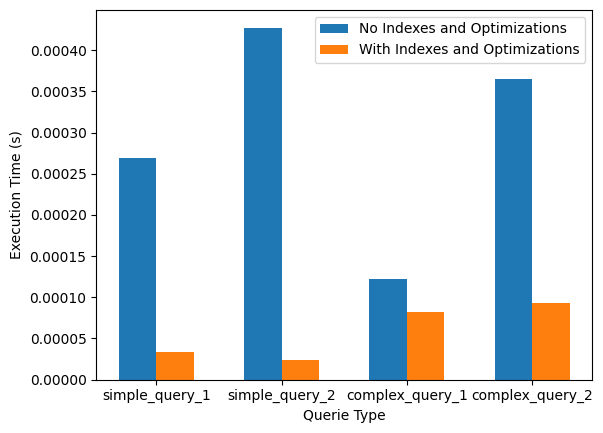

In [97]:
X_axis = np.arange(len(performance_no_index))

plt.bar(X_axis - 0.15, performance_no_index.values(), 0.3, label="No Indexes and Optimizations")
plt.bar(X_axis + 0.15, performance_index_opt.values(), 0.3, label="With Indexes and Optimizations")
plt.xticks(X_axis, performance_no_index.keys())
plt.legend()
plt.xlabel("Querie Type")
plt.ylabel("Execution Time (s)")
plt.show()

### Close Connection

In [20]:
db.close()